In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 4.6 MB/s 


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pulp import *
import matplotlib.pyplot as plt

In [4]:
trainDF = pd.read_csv('/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/TrainingData.txt', header=None)
y = trainDF[24].tolist()
trainDF = trainDF.drop(24, axis=1)
x = trainDF.values.tolist()

In [5]:
x = np.array(x)
y = np.array(y)
x_train_full = x
y_train_full = y

In [6]:
testDF = pd.read_csv('/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/TestingData.txt', header=None)
x_classify = testDF.values.tolist()


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(len(x_train),len(x_test),len(y_train),len(y_test))

8000 2000 8000 2000


In [8]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
y_pred = lda.predict(x_classify)
y_pred = [int(x) for x in y_pred]
print(len(y_pred))
print("\n LDA classifier accuracy on full Training Dataset:",lda.score(x_train_full, y_train_full))

100

 LDA classifier accuracy on full Training Dataset: 0.9403


In [9]:
print("Accuracy testing on training data:",lda.score(x_test, y_test))
print("Training accuracy:",lda.score(x_train, y_train))
predDF = pd.DataFrame({'Prediction': y_pred})
testDF = testDF.join(predDF)
testDF.to_csv("/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/TestingResults.txt", header=None, index=None)
predDF.to_csv("PredictionsOnly.txt", header=None, index=None)
print("\nPredictions are written in the file TestingResults.txt")

Accuracy testing on training data: 0.94
Training accuracy: 0.940375

Predictions are written in the file TestingResults.txt


In [10]:
excelFile = pd.read_excel ('/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/COMP3217CW2Input.xlsx', sheet_name = 'User & Task ID')
taskName = excelFile['User & Task ID'].tolist()
readyTime = excelFile['Ready Time'].tolist()
deadline = excelFile['Deadline'].tolist()
maxEnergyPerHour = excelFile['Maximum scheduled energy per hour'].tolist()
energyDemand = excelFile['Energy Demand'].tolist()
tasks = []
taskNames = []

for k in range (len(readyTime)):
    task = []
    task.append(readyTime[k])
    task.append(deadline[k])
    task.append(maxEnergyPerHour[k])
    task.append(energyDemand[k])
    taskNames.append(taskName[k])
    
    tasks.append(task)

testDF = pd.read_csv('/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/TestingResults.txt', header=None)
y_labels = testDF[24].tolist()
testDF = testDF.drop(24, axis=1)
x_data = testDF.values.tolist()

In [11]:
def plot(model, count):
    hours = [str(x) for x in range(0, 24)]
    pos = np.arange(len(hours))
    users = ['user1', 'user2', 'user3', 'user4', 'user5']
    color_list = ['blue','orange','turquoise','yellow','green']
    plot_list = []
    to_plot = []
    
    for user in users:
        temp_list = []
        for hour in hours:
            hour_list_temp = []
            task_count = 0
            for var in model.variables():
                if user == var.name.split('_')[0] and str(hour) == var.name.split('_')[2]:
                    task_count += 1
                    hour_list_temp.append(var.value())
            temp_list.append(sum(hour_list_temp))
        plot_list.append(temp_list)

    #bar chart stacked by user
    plt.bar(pos,plot_list[0],color=color_list[0],edgecolor='black',bottom=0)
    plt.bar(pos,plot_list[1],color=color_list[1],edgecolor='black',bottom=np.array(plot_list[0]))
    plt.bar(pos,plot_list[2],color=color_list[2],edgecolor='black',bottom=np.array(plot_list[0])+np.array(plot_list[1]))
    plt.bar(pos,plot_list[3],color=color_list[3],edgecolor='black',bottom=np.array(plot_list[0])+np.array(plot_list[1])+np.array(plot_list[2]))
    plt.bar(pos,plot_list[4],color=color_list[4],edgecolor='black',bottom=np.array(plot_list[0])+np.array(plot_list[1])+np.array(plot_list[2])+np.array(plot_list[3]))
    
    plt.xticks(pos, hours)
    plt.xlabel('Hour')
    plt.ylabel('Energy Usage (kW)')
    plt.title('Energy Usage Per Hour For All Users\nDay %i'%count)
    plt.legend(users,loc=0)
    image = plt.gcf()
    image.savefig('/content/drive/MyDrive/COMP3217-Course/COMP321720212022CW2A/plots/'+str(count)+'.png')
    plt.show()
    plt.clf()

    return plot_list

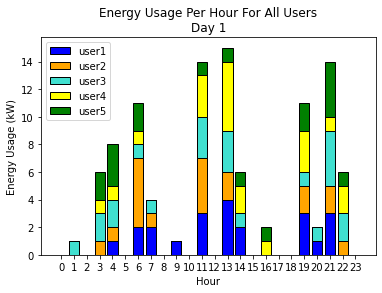

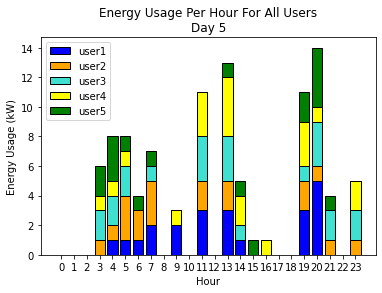

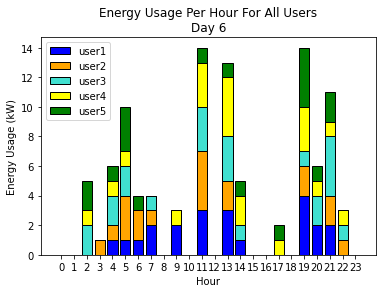

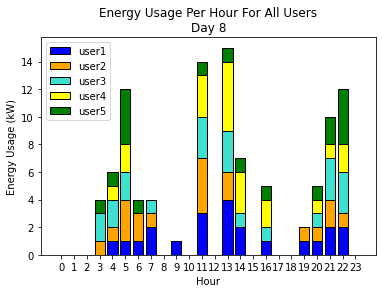

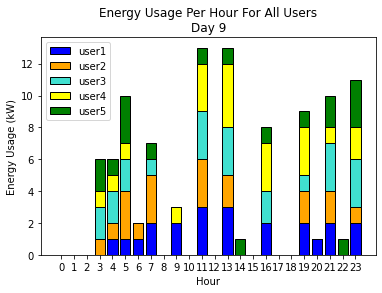

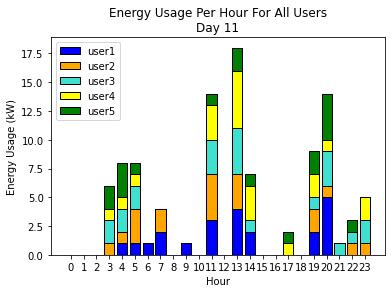

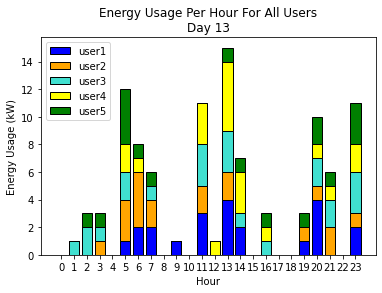

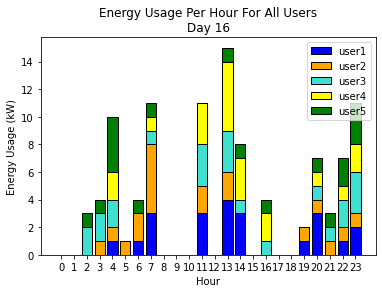

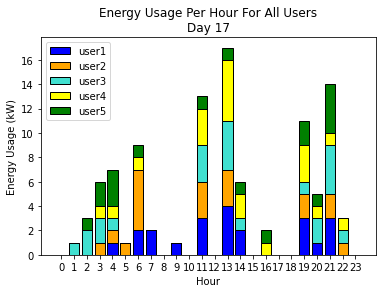

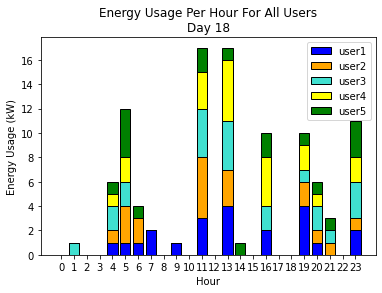

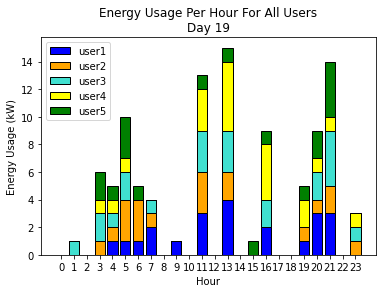

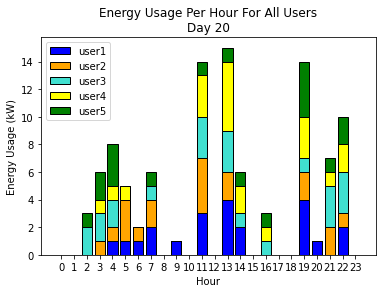

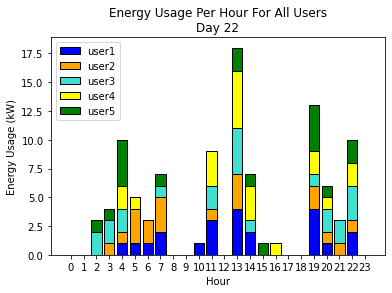

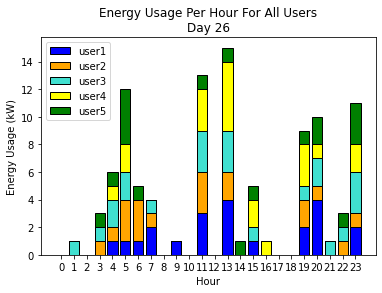

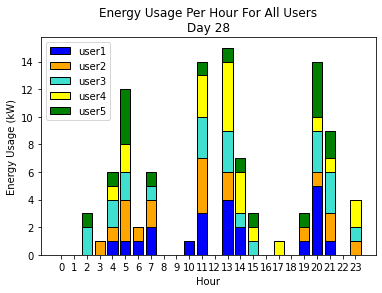

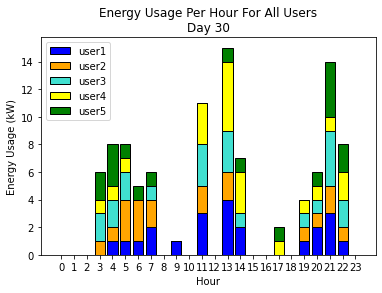

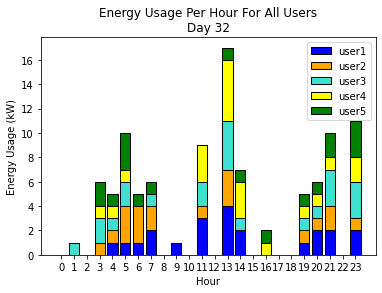

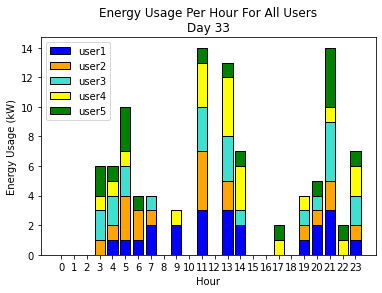

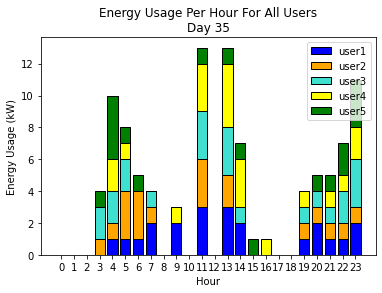

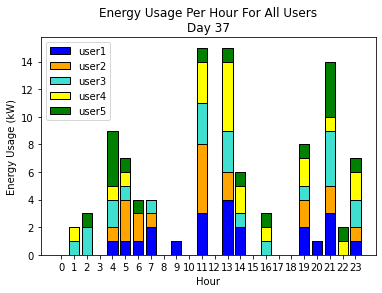

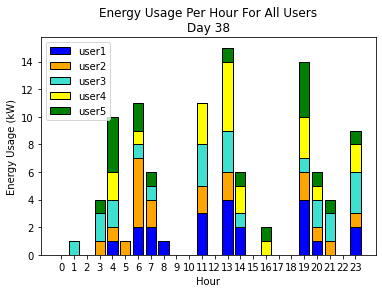

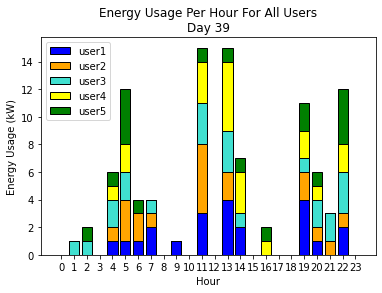

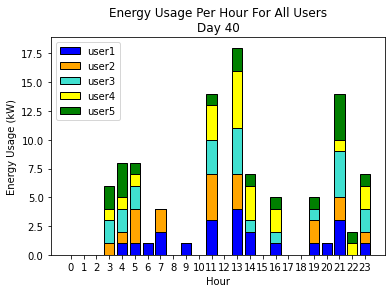

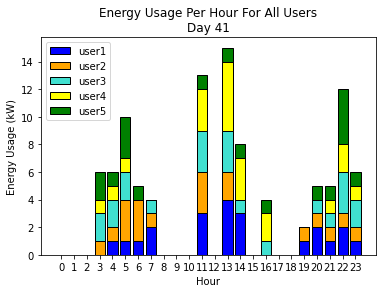

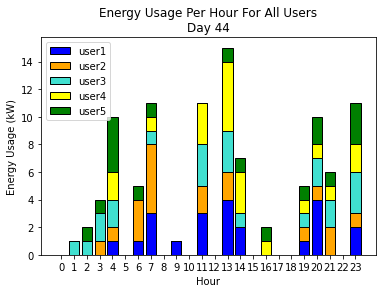

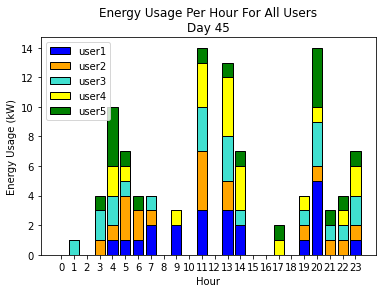

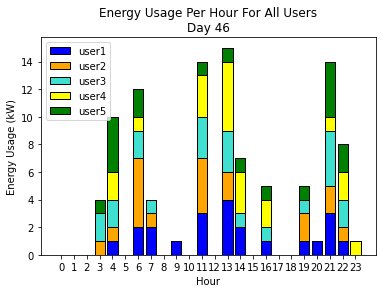

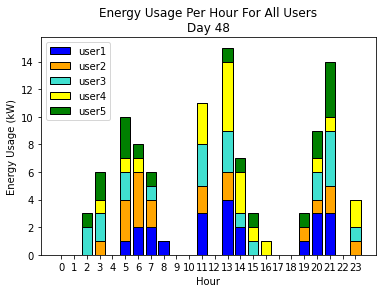

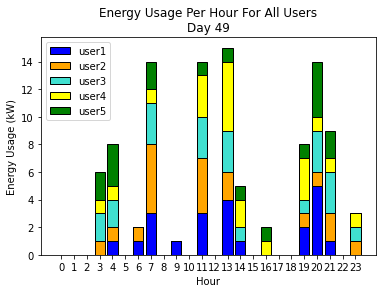

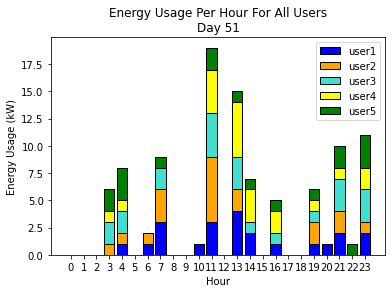

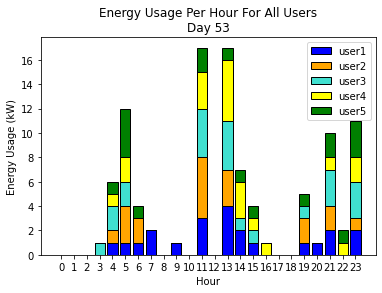

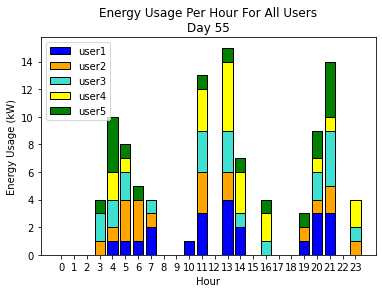

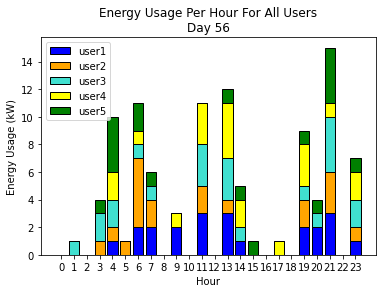

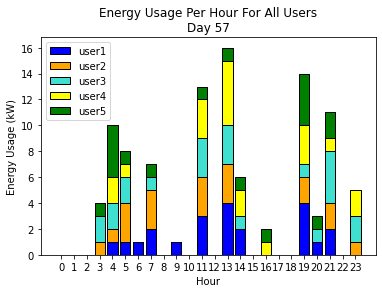

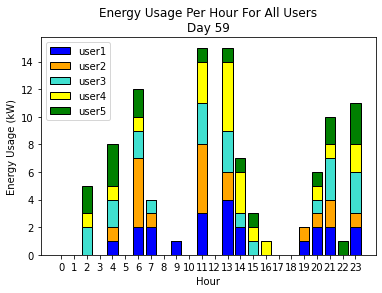

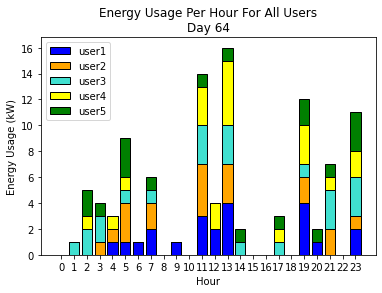

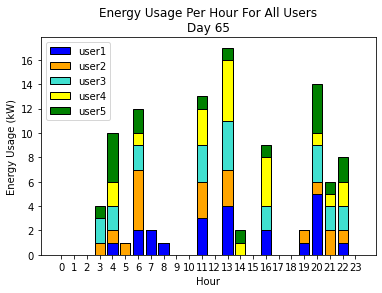

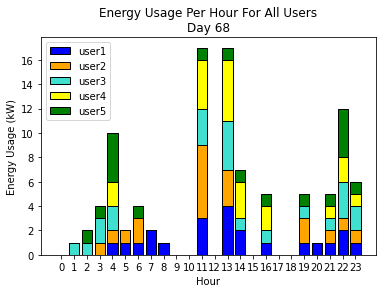

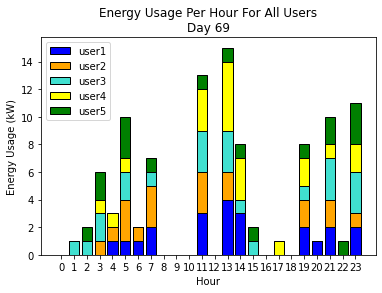

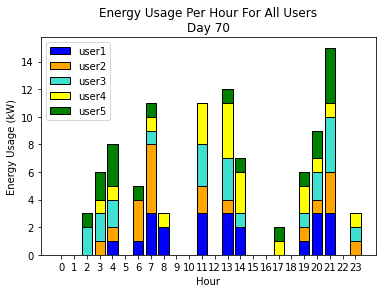

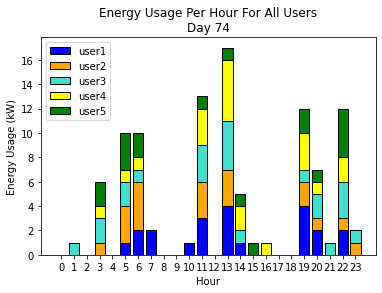

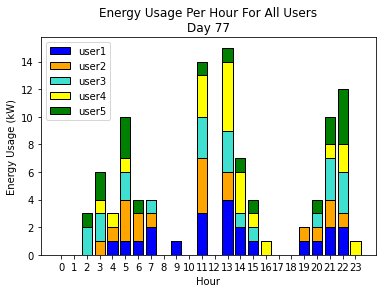

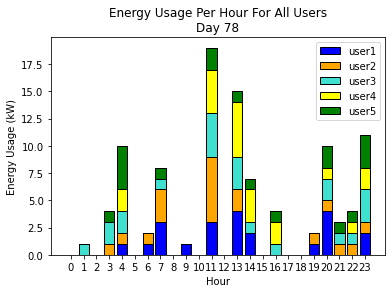

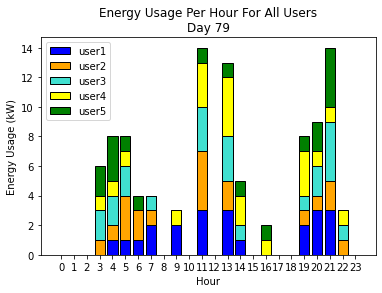

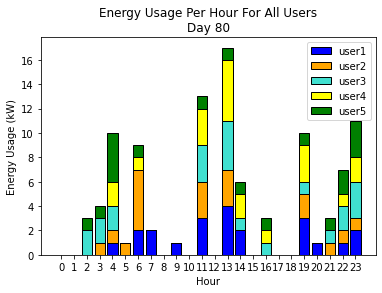

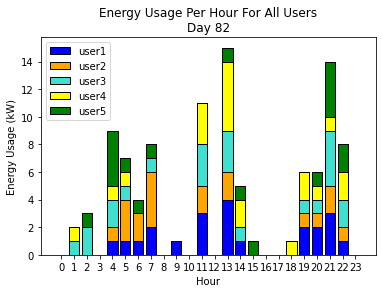

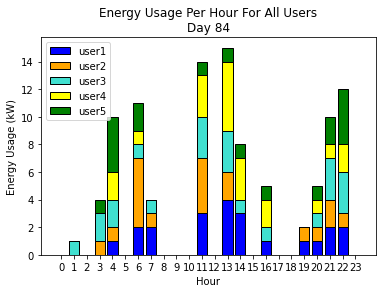

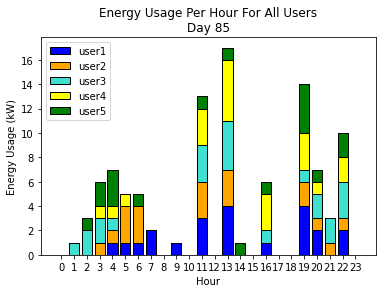

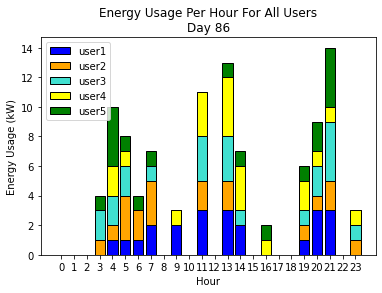

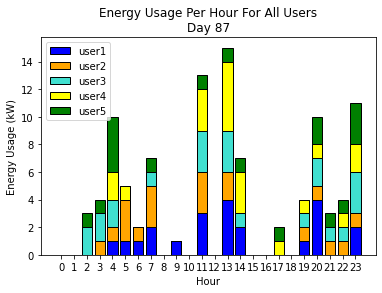

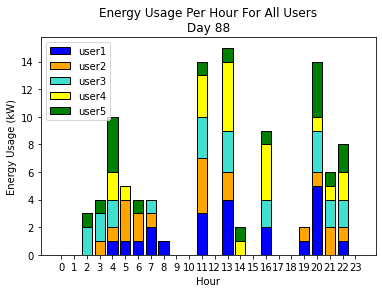

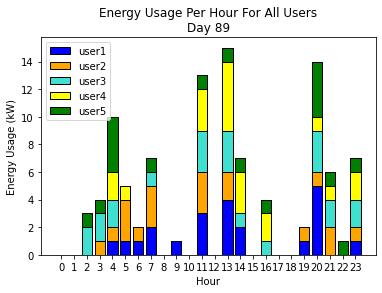

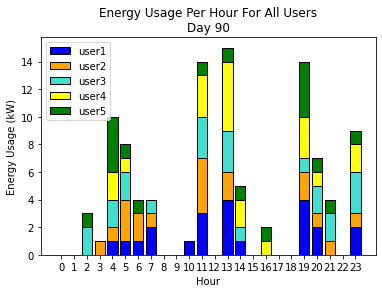

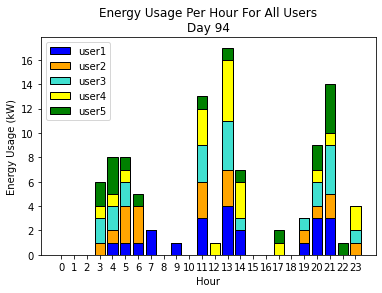

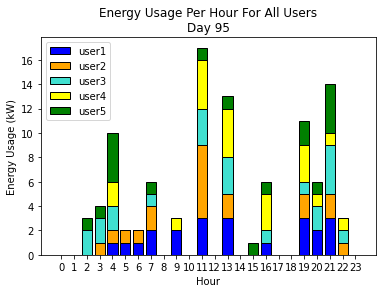

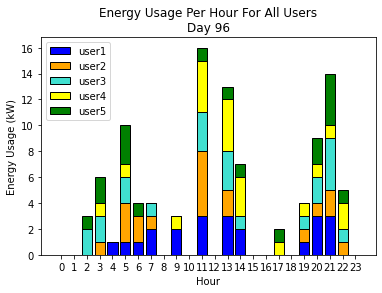

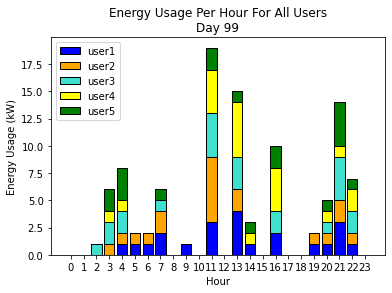

57


<Figure size 432x288 with 0 Axes>

In [12]:
answerlist=[]
for index, price_list in enumerate(x_data):
  if y_labels[index] == 1:
    vars = []
    c = []
    eq = []
    
    #create LP problem model for Minimization    
    model = LpProblem(name="scheduling-problem", sense=LpMinimize)
    
    #Loop through list of tasks
    for ind, task in enumerate(tasks):
        n = task[1] - task[0] + 1
        temp = []
        #Loop between ready_time and deadline for each task
        #Creates LP variables with given constraints and unique names
        for i in range(task[0], task[1] + 1):
            x = LpVariable(name=taskNames[ind]+'_'+str(i), lowBound=0, upBound=task[2])
            temp.append(x)
        vars.append(temp)

    #Create objective function for price (to minimize) and add to the model
    for i, task in enumerate(tasks):
        for var in vars[i]:
            price = price_list[int(var.name.split('_')[2])]
            c.append(price * var)
    model += lpSum(c)
              
    #Add additional constraints to the model      
    for i, task in enumerate(tasks):
        temp = []
        for var in vars[i]:
            temp.append(var)
        eq.append(temp)
        model += lpSum(temp) == task[3]
      
    answer = model.solve()
    answerlist.append(answer)
    plot(model,index+1)
    

#print(model)  
print(len(answerlist))    

In [13]:
for i in range(0,100):
  print("Day "+str(i+1)+":\t"+str(y_pred[i])+",")

Day 1:	1,
Day 2:	0,
Day 3:	0,
Day 4:	0,
Day 5:	1,
Day 6:	1,
Day 7:	0,
Day 8:	1,
Day 9:	1,
Day 10:	0,
Day 11:	1,
Day 12:	0,
Day 13:	1,
Day 14:	0,
Day 15:	0,
Day 16:	1,
Day 17:	1,
Day 18:	1,
Day 19:	1,
Day 20:	1,
Day 21:	0,
Day 22:	1,
Day 23:	0,
Day 24:	0,
Day 25:	0,
Day 26:	1,
Day 27:	0,
Day 28:	1,
Day 29:	0,
Day 30:	1,
Day 31:	0,
Day 32:	1,
Day 33:	1,
Day 34:	0,
Day 35:	1,
Day 36:	0,
Day 37:	1,
Day 38:	1,
Day 39:	1,
Day 40:	1,
Day 41:	1,
Day 42:	0,
Day 43:	0,
Day 44:	1,
Day 45:	1,
Day 46:	1,
Day 47:	0,
Day 48:	1,
Day 49:	1,
Day 50:	0,
Day 51:	1,
Day 52:	0,
Day 53:	1,
Day 54:	0,
Day 55:	1,
Day 56:	1,
Day 57:	1,
Day 58:	0,
Day 59:	1,
Day 60:	0,
Day 61:	0,
Day 62:	0,
Day 63:	0,
Day 64:	1,
Day 65:	1,
Day 66:	0,
Day 67:	0,
Day 68:	1,
Day 69:	1,
Day 70:	1,
Day 71:	0,
Day 72:	0,
Day 73:	0,
Day 74:	1,
Day 75:	0,
Day 76:	0,
Day 77:	1,
Day 78:	1,
Day 79:	1,
Day 80:	1,
Day 81:	0,
Day 82:	1,
Day 83:	0,
Day 84:	1,
Day 85:	1,
Day 86:	1,
Day 87:	1,
Day 88:	1,
Day 89:	1,
Day 90:	1,
Day 91:	0,
Day 92:	